# Creating an Amundsen Sea Low (ASL) index

This work is a continuation of my 2013 and 2016 papers as described [here](https://legacy.bas.ac.uk/data/absl/)

In [5]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from skimage.feature import peak_local_max

## Read in gridded monthly mean data for period 1979-2018

In [6]:
ds   = xr.open_dataset('~/DATA/ERAI/erai_Surface_MonthlyMeansFromDaily.nc')
mask = xr.open_dataset('~/DATA/ERAI/erai_invariant.nc').lsm.squeeze()

In [7]:
da = ds.msl

## Apply land-sea mask

In [8]:
da_mask = da.where(mask == 0)
da_mask.mean().values, da.mean().values # these are different, great!

(array(64511.23828125), array(42718.0625))

In [9]:
da = da.sel(latitude=slice(-55,-90))

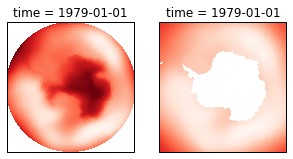

In [10]:
plt.figure(figsize=(5,5))
ax1 = plt.subplot( 121, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax1.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
da.isel(time=0).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )

ax2 = plt.subplot( 122, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )
ax2.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
da_mask.isel(time=0).plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', 
                                        transform=ccrs.PlateCarree(), add_colorbar=False )


## Definitions to identify areas of low pressure

In [11]:
def get_lows(da):
    
    invert_data   = (da*-1.).values                    # search for peaks rather than minima
    threshold_abs = np.percentile(invert_data,50)      # define threshold cut-off for peaks (inverted lows)
    
    minima_yx = peak_local_max(invert_data,            # input data
                           min_distance=4,             # peaks are separated by at least min_distance
                           num_peaks=6,                # maximum number of peaks
                           exclude_border=True,        # excludes peaks from within min_distance - pixels of the border
                           threshold_abs=threshold_abs # minimum intensity of peaks
                           )
    return minima_yx

def sector_mean(da, dict):
    a = da.sel( latitude=slice(asl_region['north'],asl_region['south']), longitude=slice(asl_region['west'],asl_region['east']) ).mean()
    return a

## Define area we are interested in

In [12]:
asl_region = {'west':170., 'east':298., 'south':-80., 'north':-60.}

## Loop through all times and identify lows
record these data in a Pandas DataFrame

In [13]:
ntime      = da.time.shape[0]
lons, lats = da.longitude.values, da.latitude.values

time_arr   = np.array([])
minima_num = np.array([])
minima_lat = np.array([])
minima_lon = np.array([])
presure    = np.array([])
ASL_Sector_Pres = np.array([]) # this should be weighted mean !!

for t in range(0,ntime):

    da_t = da.isel(time=t)
    
    minima_yx = get_lows(da_t)

    ### used masked array
    sec_pres = sector_mean(da_t.where(mask == 0),asl_region).values
    
    for i, minima in enumerate(minima_yx):
        time_arr   = np.append(time_arr,   str(da_t.time.values))
        minima_num = np.append(minima_num, i+1)
        minima_lat = np.append(minima_lat, lats[minima[0]])
        minima_lon = np.append(minima_lon, lons[minima[1]])
        presure    = np.append(presure, da_t.values[minima[0],minima[1]] / 100.)
        ASL_Sector_Pres = np.append(ASL_Sector_Pres, sec_pres / 100.)
        

### Create DataFrame
df                    = pd.DataFrame([])
df['time']            = time_arr
df['minima_number']   = minima_num.astype(int)
df['lat']             = minima_lat
df['lon']             = minima_lon
df['presure']         = presure
df['ASL_Sector_Pres'] = ASL_Sector_Pres


### show the first 7 rows

In [14]:
df.iloc[0:7]

,time,minima_number,lat,lon,presure,ASL_Sector_Pres
0,1979-01-01T00:00:00.000000000,1,-63.75,155.25,980.693906,986.090859
1,1979-01-01T00:00:00.000000000,2,-60.75,33.00,981.350781,986.090859
2,1979-01-01T00:00:00.000000000,3,-62.25,50.25,981.380391,986.090859
3,1979-01-01T00:00:00.000000000,4,-69.75,219.00,982.376328,986.090859
4,1979-01-01T00:00:00.000000000,5,-69.00,264.75,983.139063,986.090859
5,1979-01-01T00:00:00.000000000,6,-61.50,200.25,983.836953,986.090859
6,1979-02-01T00:00:00.000000000,1,-71.25,196.50,973.704375,982.956484


# Select ASL from amongst all Southern Ocean lows 
- i.e., lowest within box at each time step

In [15]:
print(df['lon'].min(), df['lon'].max(), df['lat'].min(), df['lat'].max())

### select only those points within ASL box
asl_df = df[(df['lon'] > asl_region['west']) & 
            (df['lon'] < asl_region['east']) & 
            (df['lat'] > asl_region['south']) & 
            (df['lat'] < asl_region['north']) ]

### For each time, get the row with the lowest minima_number
asl_df = asl_df.loc[asl_df.groupby('time')['minima_number'].idxmin()]

asl_df.iloc[0:4]

3.0 356.25 -85.5 -58.5


,time,minima_number,lat,lon,presure,ASL_Sector_Pres
3,1979-01-01T00:00:00.000000000,4,-69.75,219.00,982.376328,986.090859
6,1979-02-01T00:00:00.000000000,1,-71.25,196.50,973.704375,982.956484
13,1979-03-01T00:00:00.000000000,2,-69.75,225.00,972.301641,980.515234
17,1979-04-01T00:00:00.000000000,1,-68.25,273.75,967.706484,979.388359


# Plotting: location of minimas in pressure field

In [16]:
def draw_regional_box( region, transform=None ):
    '''
    Draw box around a region on a map
    region is a dictionary with west,east,south,north
    '''

    if transform == None:
        transform = ccrs.PlateCarree()

    plt.plot([region['west'], region['west']], [region['south'],region['north']], 'k-', transform=transform, linewidth=1)
    plt.plot([region['east'], region['east']], [region['south'],region['north']], 'k-', transform=transform, linewidth=1)
    for i in range( np.int(region['west']),np.int(region['east']) ): 
        plt.plot([i,i+1], [region['south'],region['south']], 'k-', transform=transform, linewidth=1)
        plt.plot([i,i+1], [region['north'],region['north']], 'k-', transform=transform, linewidth=1)

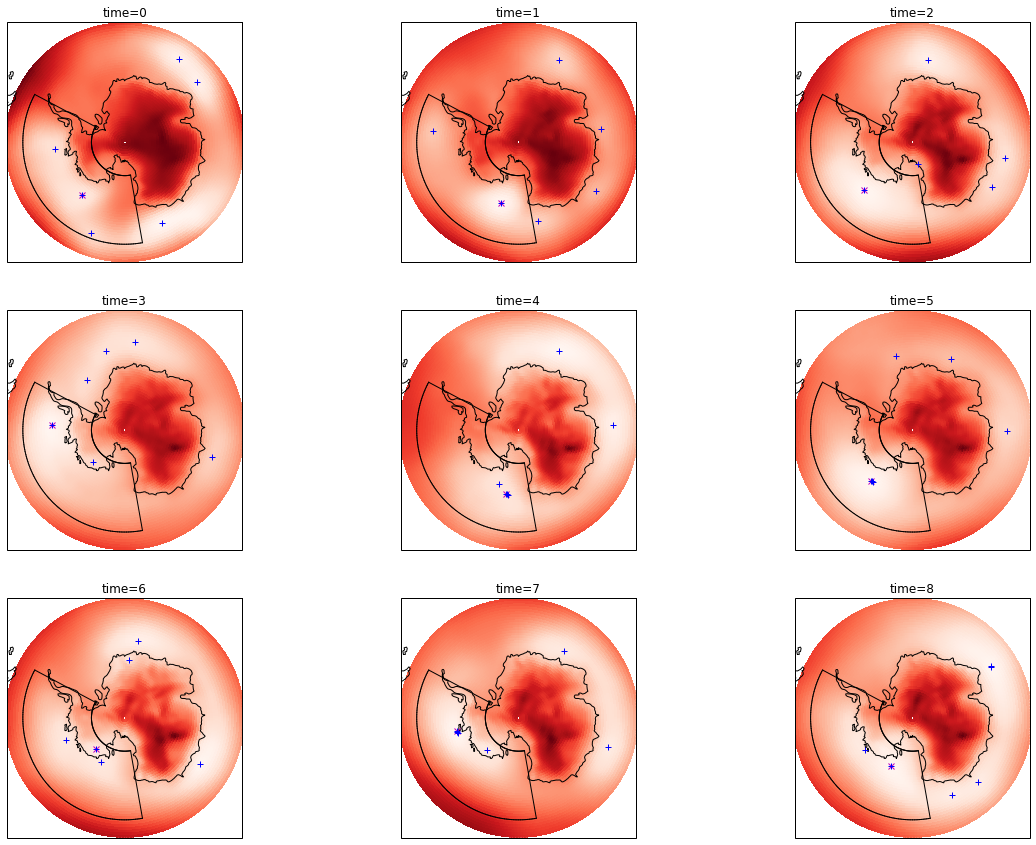

In [17]:
plt.figure(figsize=(20,15))

for i in range(0,9):

    da_2D = da.isel(time=i)
    
    ax = plt.subplot( 3,3,i+1, projection=ccrs.Stereographic(central_longitude=0., central_latitude=-90.) )

    ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree())

    result = da_2D.plot.pcolormesh( 'longitude', 'latitude', cmap='Reds', transform=ccrs.PlateCarree(), add_colorbar=False )

    # ax.coastlines(resolution='50m')
    ax.coastlines(resolution='110m')

    # plt.colorbar(result, orientation='horizontal', label=da.units, extend='both', fraction=0.046, pad=0.04)

    # ax.set_title(da.long_name+'\n', size='xx-large')
    ax.set_title('time='+str(i))
    
    ### mark ASL
    df2 = asl_df[ asl_df['time'] == str(da_2D.time.values)]
    plt.plot(df2['lon'], df2['lat'], 'mx', transform=ccrs.PlateCarree() )

    ### mark all lows
    df1 = df[ df['time'] == str(da_2D.time.values)]
    for index, row in df1.iterrows():
        plt.plot(row['lon'], row['lat'], 'b+', transform=ccrs.PlateCarree() )

    draw_regional_box(asl_region)

print('')